# EMアルゴリズム

最尤推定またはMAP推定を数値的に行う手法。これらが解析的に行えない場合に活躍する。

参考
- [【徹底解説】EMアルゴリズムをはじめからていねいに | Academaid](https://academ-aid.com/ml/em)
- [EMアルゴリズムとともだちになろう | ドクセル](https://www.docswell.com/s/mutopsy/K18DP5-2022-08-16-163818)

In [1]:
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import random


---

## 潜在変数

データ$x$の裏に潜む、$x$をよく表した**観測できない**変数。

EMアルゴリズムでは、観測されたデータ$X=(x_1, x_2, \cdots, x_n)$に対して潜在変数$Z=(z_1, z_2, \cdots, z_n)$を導入する。$x$に影響を与える潜在変数$z$を考え、それがどのように$x$に作用するかをモデル化するということ。

分布が複雑な時は、潜在変数を導入することで計算が簡単になる場合が多い。

<br>

潜在変数の導入を数学的に表現すると、それは同時分布を定めることとなる。

$$
p(x, z) = p(x|z)p(z)
$$

潜在変数の分布$p(z)$と、それがデータ$x$にどう作用するかを表す条件付き分布$p(x|z)$を定めている。


---

## 理論

ではEMアルゴリズムの計算方法を見ていく。

まず対数尤度関数を考える。

$$
\begin{align}
    \log L(\theta|X)
        &= \log \prod_{i=1}^n p(x_i;\theta) \\
        &= \sum_{i=1}^n \log p(x_i;\theta) \\
\end{align}
$$

尤度$p(x_i;\theta)$が複雑で、このまま進めても解が求められない場合を考えていく。

ここで潜在変数を導入する。

$$
p(X;\theta) = \sum_Z p(X,Z;\theta)
$$

では、この下で対数尤度を見ていく。

$$
\begin{align}
\log p(X;\theta)
    &= \log \sum_Z p(X,Z;\theta) \\
    &= \log \sum_Z q(Z) \frac{p(X,Z;\theta)}{q(Z)} \\
    &\ge \sum_Z q(Z) \log \frac{p(X,Z;\theta)}{q(Z)} \\
    &= \mathcal{L}(q(Z),\theta)
\end{align}
$$

途中の不等式は**イェンゼンの不等式**というもの。$q(Z)$はイェンゼンの不等式を使うために適当に持ち出したなんらかの確率分布。現時点では明確になっていない。  
また最後に出てきた$\mathcal{L}(q(Z),\theta)$は以後**下限**と呼ぶ。

ここで、対数尤度関数と下限の差を求めると

$$
\log p(X;\theta) - \mathcal{L}(q(Z),\theta) = D_{KL}[q(Z)||p(Z|X;\theta)]
$$

$q(Z)$と$p(Z|X,\theta)$のKLダイバージェンスになる。途中式は省略。これを以下のようにまとめる。

$$
\log p(X;\theta) = \mathcal{L}(q(Z),\theta) + D_{KL}[q(Z)||p(Z|X;\theta)]
$$

対数尤度をKLダイバージェンスと下限の和で表すことが出来た。これを最大化する。

真っ先に思いつくのは、下限とKLダイバージェンスを別々に最大化する方法である。そうすれば対数尤度も大きくなりそう。しかし、このやり方は上手くいかない。なぜかな。

まず、我々が自由に操作できる変数は以下の二つである。
- $\theta$
- $q(Z)$

この二つの変数を対数尤度が最大になるように設定したい訳だが、よく見ると、対数尤度は$q(Z)$に依存していない。したがって、$q(Z)$をいじった時に変わるものは対数尤度ではなく、下限とKLダイバージェンスの比率である。どちらかを大きくする$q(Z)$は、もう一方を小さくする$q(Z)$となる。



ではどうすべきか。正解は以下。
1. $\theta$を初期化する。
2. $\theta$を固定し、KLダイバージェンスを最小化する。
3. $q(Z)$を固定し、下限を最大化する。
4. 2, 3を繰り返す。

実際にやってみよう

まずは$\theta$の初期化だがこれは何でもよい。とりあえず$\theta_{old}$と表記しておく。

次に、その$\theta_{old}$の下でKLダイバージェンスを最小化する。つまり$D_{KL}[q(Z)||p(Z|X;\theta_{old})]=0$となる$q(Z)$を求める。  
ここで、KLダイバージェンスは二つの確率分布が完全に一致する際に唯一の0をとる。よって$q(Z)=p(Z|X;\theta_{old})$とすればよい。

では今度はその$q(Z)$を固定して下限を最大化する。つまり以下を行う。

$$
\theta_{new} = \argmax_\theta \mathcal{L}(p(Z|X;\theta_{old}), \theta)
$$

この下限を少し整理すると、以下になる。

$$
\begin{align}
    \mathcal{L}(p(Z|X;\theta_{old}),\theta)
        &= \sum_Z p(Z|X;\theta_{old}) \log \frac{p(X,Z;\theta)}{p(Z|X;\theta_{old})} \\
        &= \sum_Z p(Z|X;\theta_{old}) \log p(X,Z;\theta) + \mathrm{const} \\
        &= \mathbb{E}_{p(Z|X;\theta_{old})}\big[\log p(X,Z;\theta)\big] + \mathrm{const} \\
        &= \mathcal{Q}(\theta|\theta_{old}) + \mathrm{const}
\end{align}
$$

事後分布に関する対数尤度の期待値になった。これは$\mathcal Q(\theta,\theta_{old})$と表しておく。

最後にこの期待値を最大にする$\theta$を求め、それを新たな$\theta$とする。これは偏微分で求められる。

$$
\theta_{new} = \argmax_{\theta} \mathcal Q(\theta,\theta_{old})
$$

そして$\theta_{old} := \theta_{new}$として、同じように期待値を最大化する。これを繰り返すことで、尤度を最大化する$\theta$を求めることができる。

期待値（*Expected value*）の最大化（*Maximization*）を繰り返すため、EMアルゴリズムと呼ばれる。


---

## 混合ガウス分布の推定

混合ガウス分布のパラメータを推定しよう。この分布は、複数のガウス分布が混ざった分布。  
混合ガウス分布はEMアルゴリズムに必要な潜在変数を定義しやすく、EMアルゴリズムを適用しやすい。

ガウス分布と正規分布は同じ意味であるが、混合と付く場合ガウス分布と呼ぶことの方が多い気がするので、本節ではそう呼ぶ。

### 簡単な混合ガウス分布

以下のようなサンプルが得られたとする。

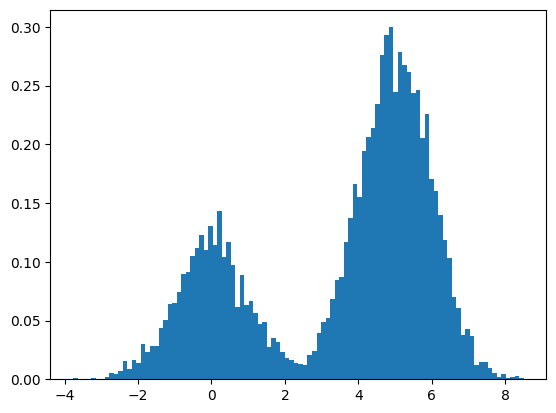

In [2]:
theta = 0.7
n = 10000

ber = dist.Bernoulli(theta)
norm0 = dist.Normal(0, 1)
norm1 = dist.Normal(5, 1)
def sampling(n):
    x = []
    for _ in range(n):
        z = ber.sample()
        if z == 0:
            x.append(norm0.sample())
        else:
            x.append(norm1.sample())
    return torch.tensor(x)

x = sampling(n)
plt.hist(x, bins=100, density=True);

このような多峰性のある分布には混合ガウス分布を仮定する事が一般的。  
上記の場合二つの峰が見られるので、二つのガウス分布が混ざった分布が仮定できそう。

混合ガウス分布のパラメータは、各ガウス分布の平均と分散、そして混合比率である。これらのパラメータをEMアルゴリズムによって推定するのだが、今回の例題では平均と分散を既知とし、比率のみを推定する問題とする。少し特殊な例だが、シンプルな例題として。

この分布の正解は以下である。

$$
z_i \sim \mathrm{Ber}(\theta) \\
x_i \sim
\begin{cases}
    \mathcal N_0 & z_i = 0 \\
    \mathcal N_1 & z_i = 1
\end{cases} \\
$$

この$\theta$が比率を表している。先で述べた通り、この$\theta$のみが未知だと仮定し、二つのガウス分布は既知で以下とする。

$$
\mathcal{N}_0 = \mathcal{N}(\mu=0, \sigma=1) \\
\mathcal{N}_1 = \mathcal{N}(\mu=5, \sigma=1) \\
$$

では求めていこう。

まずは潜在変数を考える。混合ガウス分布では、どのガウス分布から得られたかを表すカテゴリ変数を潜在変数として仮定することが一般的である。  
今回は二つのガウス分布が混ざっているので、サンプル$x_i$がそのどちらから得られたかを$0, 1$で表す潜在変数$z_i\in[0,1]$を定義しよう。  
そしてこのとき、$z_i$の分布としてベルヌーイ分布$\mathrm{Ber}(\theta)$が仮定できる。こうすることでベルヌーイ分布のパラメータ$\theta$が比率を表すようになり、この$\theta$を求める問題に落とし込める。

これらの仮定は一般的で妥当なものであり、それは上記の正解の式やソースコードを見ると納得できるかもしれない。

ではこれらの仮定を同時分布として表そう。

$$
\begin{align}
p(X,Z|\theta)
    &= p(X|Z)p(Z|\theta) \\
    &= \prod_{i=1}^n p(x_i|z_i)p(z_i|\theta) \\
    &= \prod_{i=1}^n \mathcal N_{z_i}(x_i)\mathrm{Ber}(z_i|\theta)

\end{align}
$$

次にこの同時分布の期待値を求めよう。

$$
\begin{align}
\mathcal Q(\theta, \theta_{old})
    &= \mathbb E_{p(Z|X;\theta_{old})}\big[\log p(X,Z|\theta)\big] \\
    &= \mathbb E_{p(Z|X;\theta_{old})}\Big[\log\prod_i\mathcal N_{z_i}(x_i)\mathrm{Ber}(z_i|\theta)\Big] \\
    &= \sum_i \mathbb E_{p(z_i|x_i;\theta_{old})}\Big[\log \mathrm{Ber}(z_i|\theta)\Big] + \mathrm{const} \\
\end{align}
$$

$\log$の中の積を和で表し、その$\Sigma$を外に出した。  
$\mathcal Q$は後程$\theta$で偏微分するため、$\theta$に関係のないガウス分布の項は定数として無視する。

引き続き変形していく。$\Sigma$の中を計算する。

$$
\begin{align}
\mathbb E_{p(z_i|x_i;\theta_{old})}\Big[\log\mathrm{Ber}(z_i|\theta)\Big]
    &= \sum_{z_i}p(z_i|x_i;\theta_{old})\log\mathrm{Ber}(z_i|\theta) \\
    &= p(0|x_i;\theta_{old})\log\mathrm{Ber}(0|\theta) + p(1|x_i;\theta_{old})\log\mathrm{Ber}(1|\theta) \\
    &= r_{i0}\log(1-\theta) + r_{i1}\log(\theta)
\end{align}
$$

$p(k|x_i;\theta_{old})$は$r_{ik}$と表した。これは負担率とも呼ばれる。

では、$\mathcal Q$を$\theta$で偏微分していく。

$$
\begin{align}
\frac{\partial\mathcal Q}{\partial\theta}
    &= \frac{\partial}{\partial\theta}\sum_i\big(r_{i0}\log(1-\theta) + r_{i1}\log(\theta)\big) \\
    &= \sum_i\frac{\partial}{\partial\theta}\big(r_{i0}\log(1-\theta)\big) + \sum_i\frac{\partial}{\partial\theta}\big(r_{i1}\log(\theta)\big) \\
    &= \sum_i\frac{r_{i1}}{\theta} - \sum_i\frac{r_{i0}}{1-\theta} \\
\end{align}
$$

これが0になるときの$\theta$を計算すると、以下となる。

$$
\theta = \frac{\sum_i r_{i1}}{\sum_i r_{i0} + \sum_i r_{i1}}
$$

In [3]:
theta = 0.3

In [4]:
def return_new_theta(theta, X):
    j0 = (1 - theta) * norm0.log_prob(X).exp()
    j1 = theta * norm1.log_prob(X).exp()
    r0 = (j0 / (j1 + j0)).sum()
    r1 = (j1 / (j1 + j0)).sum()
    return (r1 / (r1 + r0)).item()

In [5]:
for _ in range(10):
    print(theta)
    theta = return_new_theta(theta, x)

0.3
0.6960307955741882
0.7037356495857239
0.7038848400115967
0.7038877606391907
0.7038877606391907
0.7038877606391907
0.7038877606391907
0.7038877606391907
0.7038877606391907


### 一般的な混合ガウス分布

こんな分布を考える

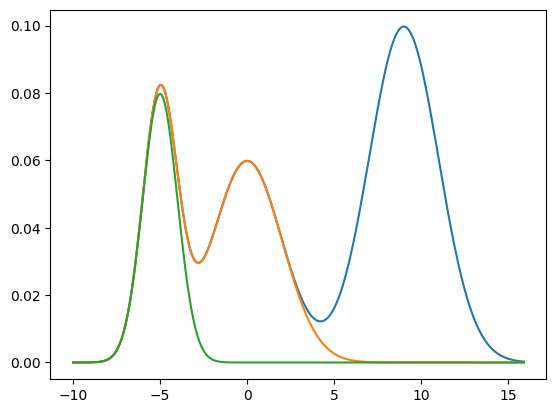

In [6]:
pi = [0.2, 0.3, 0.5]
mu = [-5., 0., 9.]
sigma = [1., 2., 2.]

norm = [dist.Normal(m, s) for m, s in zip(mu, sigma)]

ax = torch.arange(-10, 16, 0.1)
y = torch.stack([p * n.log_prob(ax).exp() for n, p in zip(norm, pi)])
for i in range(1, 3):
    y[i] += y[i-1]
plt.plot(ax, y.T.flip(-1));

これが3つのガウス分布を足して作られた真の分布